# Stubble Burning Detection via Time Series Analysis

This notebook implements a deep learning pipeline to detect stubble burning (burned vs. unburned) using satellite time series data. We employ a Transformer-based architecture, custom data handling for variable-length sequences, and performs the following experiment:

*Normalized Sequence Experiment:* The data is split by location IDs and sequences are normalized (truncated/padded).

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import math
import time

torch.manual_seed(42)
np.random.seed(42)

FEATURE_COLS = ['NDVI', 'NBR', 'B4', 'B8', 'B11']
HIDDEN_SIZE = 64
NUM_HEADS = 4
NUM_ENCODER_LAYERS = 3
DROPOUT = 0.1
LEARNING_RATE = 0.0005
BATCH_SIZE = 32
NUM_EPOCHS = 50
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

NORMALIZE_SEQUENCE_LENGTH = True  
MAX_SEQ_LENGTH = 15               
MIN_SEQ_LENGTH = 10               


## Dataset Preparation

We define a custom PyTorch dataset (`TimeSeriesDataset`) that groups observations by `location_id`, scales the features, sorts the data by date, and optionally truncates or filters sequences. A custom collate function is also provided to pad variable-length sequences and create an attention mask.

In [ ]:
class TimeSeriesDataset(Dataset):
    def __init__(self, dataframe, feature_cols, target_col='burn_status', max_seq_length=None, min_seq_length=None, scaler=None):
        self.df = dataframe.copy()
        self.feature_cols = feature_cols
        self.target_col = target_col
        self.max_seq_length = max_seq_length
        self.min_seq_length = min_seq_length
        
        self.df['date_num'] = pd.to_datetime(self.df['date']).astype(int) // 10**9
        
        if scaler is None:
            self.scaler = StandardScaler()
            self.df[feature_cols] = self.scaler.fit_transform(self.df[feature_cols])
        else:
            self.scaler = scaler
            self.df[feature_cols] = self.scaler.transform(self.df[feature_cols])
        
        groups = list(self.df.groupby('location_id'))
        if min_seq_length is not None:
            groups = [(loc, grp) for loc, grp in groups if len(grp) >= min_seq_length]
        self.location_groups = groups
        self.sequence_lengths = {loc: len(grp) for loc, grp in groups}
        
    def __len__(self):
        return len(self.location_groups)
    
    def __getitem__(self, idx):
        location_id, group = self.location_groups[idx]
        group = group.sort_values(by='date_num')
        features = group[self.feature_cols].values
        if self.max_seq_length is not None and len(features) > self.max_seq_length:
            features = features[-self.max_seq_length:]
        burn_status = group[self.target_col].iloc[0]
        year = int(group['year'].iloc[0]) if 'year' in group.columns else None
        return (torch.FloatTensor(features),
                torch.FloatTensor([burn_status]),
                len(features),
                location_id,
                year)

def collate_fn(batch):
    features, targets, lengths, loc_ids, years = zip(*batch)
    features_padded = pad_sequence(features, batch_first=True)
    targets = torch.stack(targets)
    lengths = torch.LongTensor(lengths)
    max_len = features_padded.size(1)
    attention_mask = torch.zeros(len(batch), max_len)
    for i, l in enumerate(lengths):
        attention_mask[i, :l] = 1
    metadata = {'location_ids': loc_ids,
                'years': years if years[0] is not None else None,
                'lengths': lengths}
    return features_padded, targets, lengths, attention_mask, metadata


## Model Architecture

We use a Transformer-based model for our time series classification task. A positional encoding module is used to add temporal context to the input data, and the Transformer encoder processes the sequence data before outputting a binary probability.

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0)/d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_size, hidden_size, num_heads, num_encoder_layers, dropout=0.1):
        super(TimeSeriesTransformer, self).__init__()
        self.input_projection = nn.Linear(input_size, hidden_size)
        self.pos_encoder = PositionalEncoding(hidden_size)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_size,
            nhead=num_heads,
            dim_feedforward=hidden_size * 4,
            dropout=dropout,
            batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.output_projection = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, attention_mask=None):
        x = self.input_projection(x)
        x = self.pos_encoder(x)
        key_padding_mask = (attention_mask == 0) if attention_mask is not None else None
        enc_out = self.encoder(x, src_key_padding_mask=key_padding_mask)
        if attention_mask is not None:
            masked = enc_out * attention_mask.unsqueeze(-1)
            pooled = masked.sum(dim=1) / attention_mask.sum(dim=1, keepdim=True).clamp(min=1e-10)
        else:
            pooled = enc_out.mean(dim=1)
        out = self.sigmoid(self.output_projection(pooled))
        return out


## Training & Evaluation Utilities

This section provides utility functions:
- **calculate_metrics:** Computes precision, recall, F1, and the confusion matrix.
- **train_model:** Trains the model using early stopping and a learning rate scheduler.
- **evaluate_model:** Evaluates the model on a test set and prints performance metrics.

In [73]:
def calculate_metrics(targets, preds):
    if isinstance(targets, torch.Tensor):
        targets = targets.cpu().numpy()
    if isinstance(preds, torch.Tensor):
        preds = preds.cpu().numpy()
    preds_binary = (np.array(preds) > 0.5).astype(float)
    precision = precision_score(targets, preds_binary, zero_division=0)
    recall = recall_score(targets, preds_binary, zero_division=0)
    f1 = f1_score(targets, preds_binary, zero_division=0)
    tn, fp, fn, tp = confusion_matrix(targets, preds_binary, labels=[0,1]).ravel()
    return {'precision': precision, 'recall': recall, 'f1': f1,
            'true_positives': tp, 'false_positives': fp,
            'true_negatives': tn, 'false_negatives': fn}

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, scheduler=None):
    model.to(device)
    history = {'train_loss': [], 'val_loss': [],
               'train_acc': [], 'val_acc': [],
               'val_f1': []}
    best_val_f1 = 0.0
    best_state = None
    print("Training...")
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        total = 0
        for features, targets, _, attention_mask, _ in train_loader:
            features = features.to(device)
            targets = targets.to(device)
            attention_mask = attention_mask.to(device)
            outputs = model(features, attention_mask)
            loss = criterion(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            train_loss += loss.item()
            preds = (outputs > 0.5).float()
            train_correct += (preds == targets).sum().item()
            total += targets.size(0)
        train_loss /= len(train_loader)
        train_acc = train_correct / total
        
        model.eval()
        val_loss = 0.0
        val_correct = 0
        total_val = 0
        all_val_targets = []
        all_val_preds = []
        with torch.no_grad():
            for features, targets, _, attention_mask, _ in val_loader:
                features = features.to(device)
                targets = targets.to(device)
                attention_mask = attention_mask.to(device)
                outputs = model(features, attention_mask)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                preds = (outputs > 0.5).float()
                val_correct += (preds == targets).sum().item()
                total_val += targets.size(0)
                all_val_targets.extend(targets.cpu().numpy())
                all_val_preds.extend(outputs.cpu().numpy())
        val_loss /= len(val_loader)
        val_acc = val_correct / total_val
        val_metrics = calculate_metrics(np.array(all_val_targets), np.array(all_val_preds))
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_metrics['f1'])
        if scheduler is not None:
            if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_loss)
            else:
                scheduler.step()
        if val_metrics['f1'] > best_val_f1:
            best_val_f1 = val_metrics['f1']
            best_state = model.state_dict().copy()
        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss {train_loss:.4f}, Train Acc {train_acc:.4f}, "
              f"Val Loss {val_loss:.4f}, Val Acc {val_acc:.4f}, Val F1 {val_metrics['f1']:.4f}")
    if best_state is not None:
        model.load_state_dict(best_state)
    print("Training complete. Best Val F1:", best_val_f1)
    return model, history

def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_targets = []
    all_outputs = []
    with torch.no_grad():
        for features, targets, _, attention_mask, metadata in test_loader:
            features = features.to(device)
            targets = targets.to(device)
            attention_mask = attention_mask.to(device)
            outputs = model(features, attention_mask)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            preds = (outputs > 0.5).float()
            correct += (preds == targets).sum().item()
            total += targets.size(0)
            all_targets.extend(targets.cpu().numpy())
            all_outputs.extend(outputs.cpu().numpy())
    test_loss /= len(test_loader)
    acc = correct / total
    metrics = calculate_metrics(np.array(all_targets), np.array(all_outputs))
    metrics['loss'] = test_loss
    metrics['accuracy'] = acc
    print("Evaluation summary:")
    print(f"Loss: {test_loss:.4f} | Accuracy: {acc:.4f} | F1: {metrics['f1']:.4f}")
    return metrics, all_targets, all_outputs


## Analysis & Visualization

These functions produce visual outputs to help us interpret training dynamics and model performance:
- Loss/accuracy/F1 curves
- Confusion matrix plot
- Permutation-based feature importance bar chart
- Sequence length vs. prediction probability scatter plot
- Yearly performance bar chart

In [74]:
def plot_training_history(history, save_path='training_history.png'):
    plt.figure(figsize=(15,10))
    plt.subplot(2,2,1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()
    
    plt.subplot(2,2,2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Curve")
    plt.legend()
    
    plt.subplot(2,2,3)
    plt.plot(history['val_f1'], label='Val F1', color='green')
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.title("Validation F1 Score")
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    plt.savefig(save_path)
    plt.close()

def plot_confusion_matrix(true_labels, predicted_labels, save_path='confusion_matrix.png'):
    binary_preds = (np.array(predicted_labels) > 0.5).astype(int)
    cm = confusion_matrix(true_labels, binary_preds)
    plt.figure(figsize=(6,5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    classes = ['Not Burned', 'Burned']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i,j],'d'),
                     horizontalalignment="center",
                     color="white" if cm[i,j] > thresh else "black")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()
    plt.savefig(save_path)
    plt.close()

def perform_feature_importance_analysis(model, test_loader, device, feature_names=FEATURE_COLS):
    model.eval()
    all_targets = []
    all_outputs = []
    with torch.no_grad():
        for features, targets, lengths, attention_mask, _ in test_loader:
            features = features.to(device)
            targets = targets.to(device)
            attention_mask = attention_mask.to(device)
            outputs = model(features, attention_mask)
            all_targets.extend(targets.cpu().numpy())
            all_outputs.extend(outputs.cpu().numpy())
    baseline_f1 = f1_score(np.array(all_targets), (np.array(all_outputs) > 0.5).astype(int), zero_division=0)
    importance = {}
    for feat_idx, feat in enumerate(feature_names):
        permuted_outputs = []
        with torch.no_grad():
            for features, targets, lengths, attention_mask, _ in test_loader:
                features_perm = features.clone()
                for i in range(features.shape[0]):
                    seq_len = lengths[i].item()
                    perm_vals = np.random.permutation(features[i, :seq_len, feat_idx].cpu().numpy())
                    features_perm[i, :seq_len, feat_idx] = torch.tensor(perm_vals, dtype=torch.float32)
                features_perm = features_perm.to(device)
                attention_mask = attention_mask.to(device)
                outputs = model(features_perm, attention_mask)
                permuted_outputs.extend(outputs.cpu().numpy())
        permuted_f1 = f1_score(np.array(all_targets), (np.array(permuted_outputs)>0.5).astype(int), zero_division=0)
        importance[feat] = baseline_f1 - permuted_f1
    total_imp = sum(importance.values())
    norm_importance = {k: (v/total_imp)*100 for k,v in importance.items()} if total_imp > 0 else importance
    plt.figure(figsize=(10,6))
    plt.bar(norm_importance.keys(), norm_importance.values())
    plt.xlabel("Feature")
    plt.ylabel("% Importance")
    plt.title("Feature Importance")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    plt.savefig('feature_importance.png')
    plt.close()
    return norm_importance


## Normalized Sequence Experiment

In this section, we run the experiment using normalized sequence lengths. The data is split by location IDs and sequences are truncated to a maximum length of 15 (with a minimum of 10). The model is trained, evaluated, and various visualizations (training curves, confusion matrix, and feature importance) are generated.


Running Normalized Sequence Experiment
Dataset shape: (57062, 12)
Unique locations: 2768
Class distribution: {0: 1384, 1: 1384}
Sequence length statistics:
  Overall: Min: 6, Mean: 20.61, Median: 17.0, Max: 140
  Burned: Min: 10, Mean: 15.98, Median: 17.0, Max: 20
  Unburned: Min: 6, Mean: 25.25, Median: 19.0, Max: 140


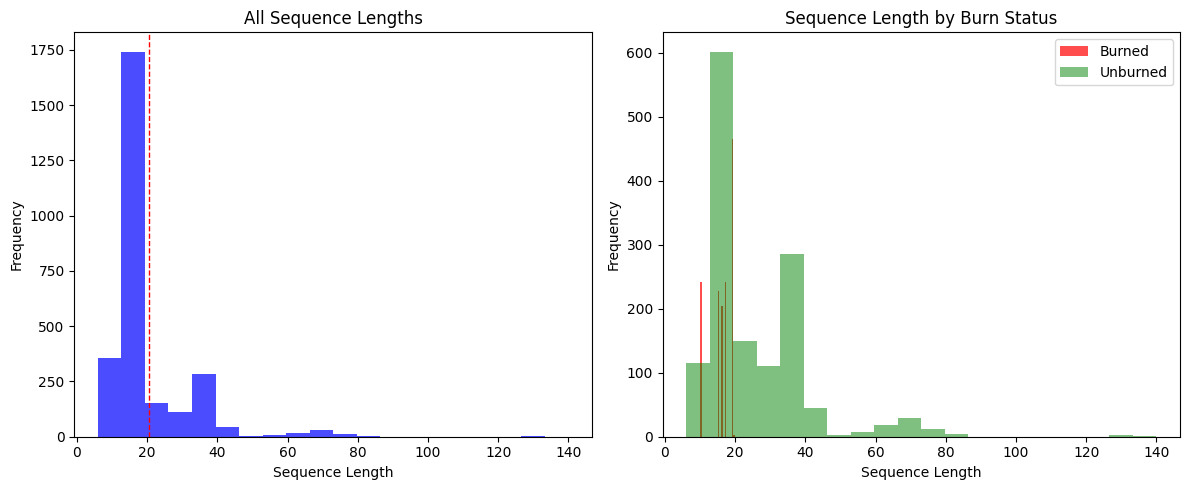

Dataset sizes: Train 1635, Val 541, Test 544
Training model...
Training...


c:\Users\Dell\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50: Train Loss 0.3391, Train Acc 0.8587, Val Loss 0.2150, Val Acc 0.9205, Val F1 0.9275
Epoch 2/50: Train Loss 0.2194, Train Acc 0.9272, Val Loss 0.1975, Val Acc 0.9020, Val F1 0.8994
Epoch 3/50: Train Loss 0.1579, Train Acc 0.9468, Val Loss 0.1546, Val Acc 0.9519, Val F1 0.9549
Epoch 4/50: Train Loss 0.1076, Train Acc 0.9706, Val Loss 0.0706, Val Acc 0.9778, Val F1 0.9786
Epoch 5/50: Train Loss 0.0986, Train Acc 0.9725, Val Loss 0.0818, Val Acc 0.9760, Val F1 0.9769
Epoch 6/50: Train Loss 0.0901, Train Acc 0.9749, Val Loss 0.0675, Val Acc 0.9815, Val F1 0.9821
Epoch 7/50: Train Loss 0.0855, Train Acc 0.9768, Val Loss 0.0448, Val Acc 0.9908, Val F1 0.9910
Epoch 8/50: Train Loss 0.0654, Train Acc 0.9810, Val Loss 0.0880, Val Acc 0.9778, Val F1 0.9786
Epoch 9/50: Train Loss 0.0530, Train Acc 0.9878, Val Loss 0.0621, Val Acc 0.9871, Val F1 0.9874
Epoch 10/50: Train Loss 0.0565, Train Acc 0.9835, Val Loss 0.0700, Val Acc 0.9834, Val F1 0.9839
Epoch 11/50: Train Loss 0.0501, Train A

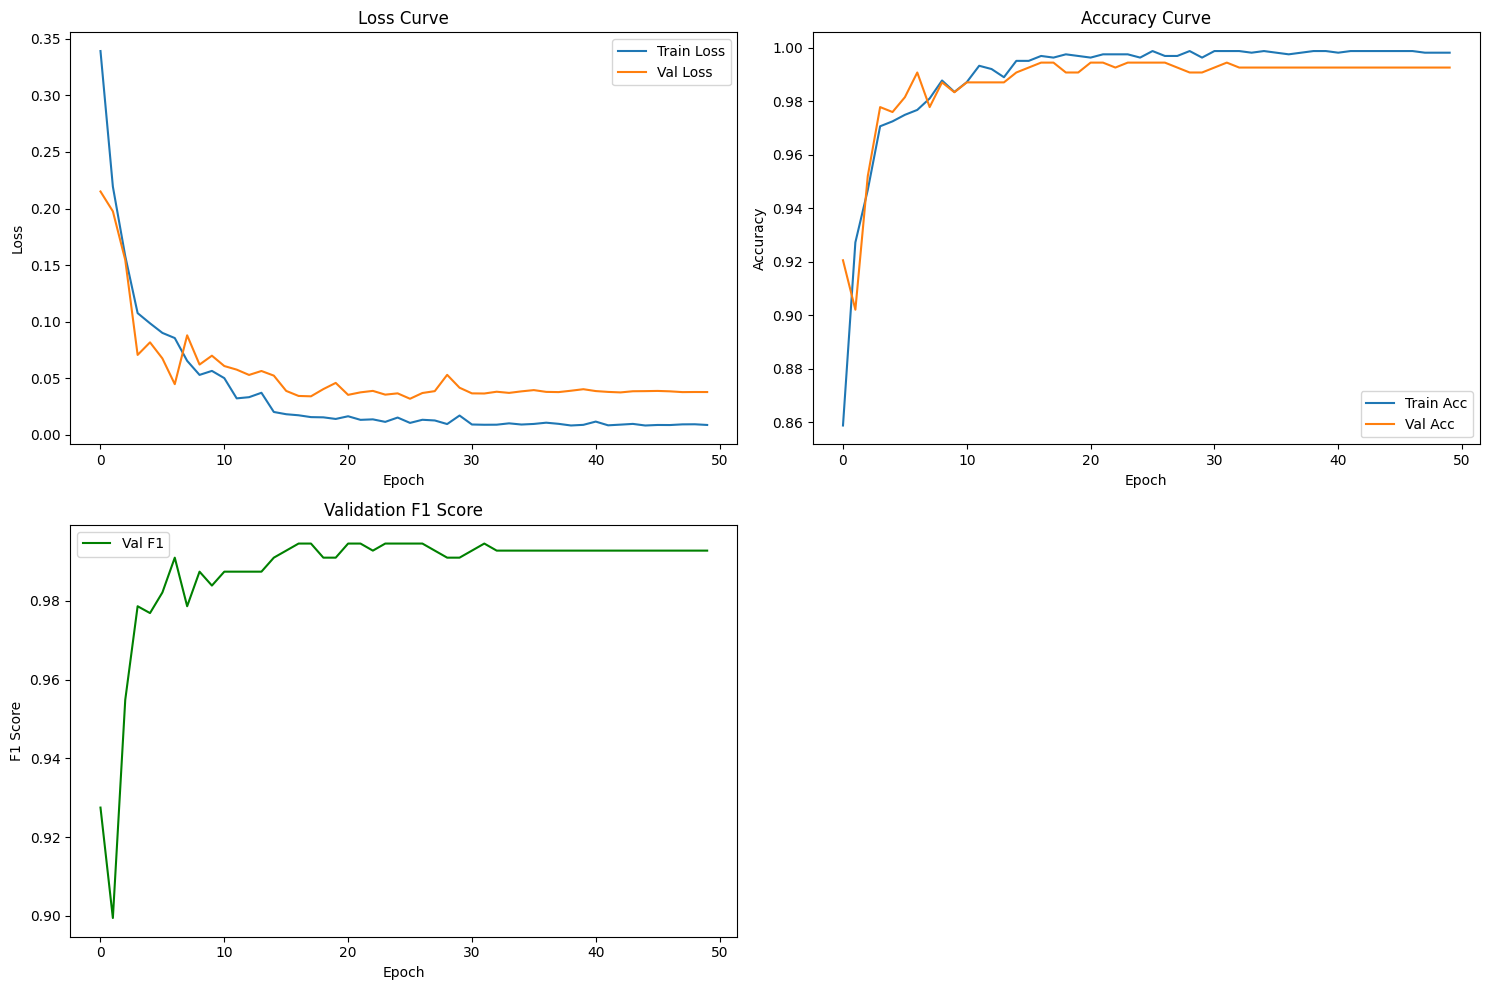

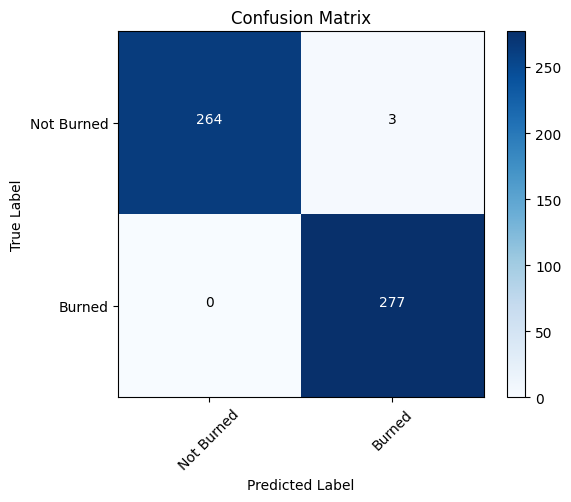

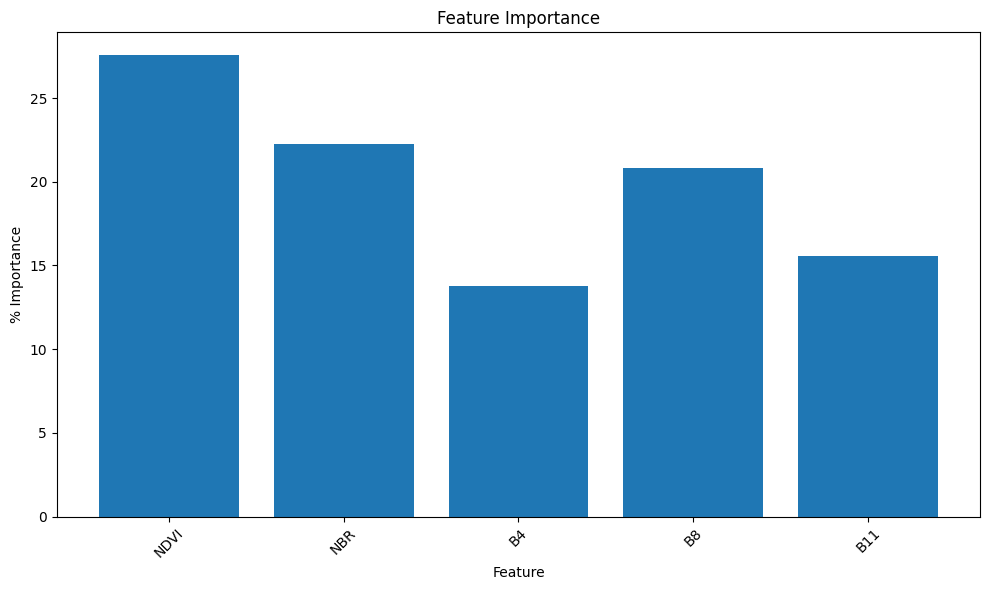

Normalized sequence experiment completed.


In [ ]:
def run_normalized_sequence_experiment():
    print("\n" + "="*80)
    print("Running Normalized Sequence Experiment")
    print("="*80)
    
    try:
        df = pd.read_csv('combined_timeseries_dataset.csv')
    except FileNotFoundError:
        df = pd.read_csv('/kaggle/input/combinedds/combined_timeseries_dataset.csv')
    
    print(f"Dataset shape: {df.shape}")
    print(f"Unique locations: {df['location_id'].nunique()}")
    
    location_burn_status = df.groupby('location_id')['burn_status'].first().reset_index()
    print("Class distribution:", location_burn_status['burn_status'].value_counts().to_dict())
    
    train_val, test = train_test_split(location_burn_status, test_size=0.2, random_state=42, stratify=location_burn_status['burn_status'])
    train, val = train_test_split(train_val, test_size=0.25, random_state=42, stratify=train_val['burn_status'])
    
    train_ids = train['location_id'].values
    val_ids = val['location_id'].values
    test_ids = test['location_id'].values
    
    train_data = df[df['location_id'].isin(train_ids)]
    val_data = df[df['location_id'].isin(val_ids)]
    test_data = df[df['location_id'].isin(test_ids)]
    
    train_dataset = TimeSeriesDataset(train_data, FEATURE_COLS, max_seq_length=MAX_SEQ_LENGTH, min_seq_length=MIN_SEQ_LENGTH)
    val_dataset = TimeSeriesDataset(val_data, FEATURE_COLS, max_seq_length=MAX_SEQ_LENGTH, min_seq_length=MIN_SEQ_LENGTH)
    test_dataset = TimeSeriesDataset(test_data, FEATURE_COLS, max_seq_length=MAX_SEQ_LENGTH, min_seq_length=MIN_SEQ_LENGTH)
    
    print(f"Dataset sizes: Train {len(train_dataset)}, Val {len(val_dataset)}, Test {len(test_dataset)}")
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
    
    model = TimeSeriesTransformer(input_size=len(FEATURE_COLS), hidden_size=HIDDEN_SIZE,
                                  num_heads=NUM_HEADS, num_encoder_layers=NUM_ENCODER_LAYERS, dropout=DROPOUT)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True, min_lr=1e-6)
    
    print("Training model...")
    trained_model, history = train_model(model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS, DEVICE, scheduler)
    
    print("Evaluating model...")
    test_metrics, targets, raw_preds = evaluate_model(trained_model, test_loader, criterion, DEVICE)
    
    plot_training_history(history, save_path='normalized_seq_training_history.png')
    plot_confusion_matrix(targets, raw_preds, save_path='normalized_seq_confusion_matrix.png')
    norm_feature_importance = perform_feature_importance_analysis(trained_model, test_loader, DEVICE)
    
    print("Normalized sequence experiment completed.")
    return test_metrics, norm_feature_importance, history

norm_metrics, norm_importance, norm_history = run_normalized_sequence_experiment()